In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# Sklearn imports
from sklearn.datasets import *
from scipy.stats import randint as rint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classification repo imports
from Garg_Classif_roc import final_mod_perf
from Garg_Classif_plotting import outlier_analysis
from Garg_Preprocessing import outlier_det
from High_Level_Train_Score import dat_preprocess,make_train_pipe,tune_roc

# Quick useful numpy functions
roundnp = np.vectorize(lambda t: round(t,3))

# Notebook Output viewing settings 
import warnings
warnings.filterwarnings('ignore')

## Using sklearns Breast Implant Dataset as a example

In [3]:
# Load Sample Dataset
breast = load_breast_cancer()
# Creating a single dataframe for the target and the predictors
df = pd.DataFrame(data = breast.data,columns = breast.feature_names)
tar = pd.DataFrame(data =  breast.target,columns = ['outcome'])
df = pd.concat((df,tar),axis = 1)

#Randomly Adding missing values to mimic a more real life data set
# Adding Nan's to first two of the predictor columns
df.iloc[0:25,0:2] = np.nan
# Adding categorical variables 
df['cat1'] = np.where(df['mean radius']>17,'hi','bye')
df['cat2'] = df.apply(lambda x: 'to' if x['mean radius'] < 13 
                      else np.nan if x['mean radius'] < 18 else 'no',axis = 1)

No of rows with outcome variable not populated : 0
Orignal row count : 569
Deduplicated row count : 569
Variables with some missing values (ie > 0 percent):
mean radius     4.4
mean texture    4.4
dtype: float64
No predictors with missing percent more than 30
 
Encoding for the outcome variable
{0: 0, 1: 1}
MODEL TYPE : GBC

Model with rank: 1
Mean validation accuracy : 0.9631  (std: 0.01)
Parameters: {'gbc__n_estimators': 200, 'gbc__min_samples_split': 0.1, 'gbc__learning_rate': 0.1, 'PCA__n_components': 26}

Model with rank: 2
Mean validation accuracy : 0.9340  (std: 0.04)
Parameters: {'gbc__n_estimators': 50, 'gbc__min_samples_split': 0.8, 'gbc__learning_rate': 0.1, 'PCA__n_components': 16}

Model with rank: 3
Mean validation accuracy : 0.9077  (std: 0.03)
Parameters: {'gbc__n_estimators': 200, 'gbc__min_samples_split': 0.8, 'gbc__learning_rate': 0.005, 'PCA__n_components': 10}

-----------------      ------------------

MODEL TYPE : RF

Model with rank: 1
Mean validation accuracy :

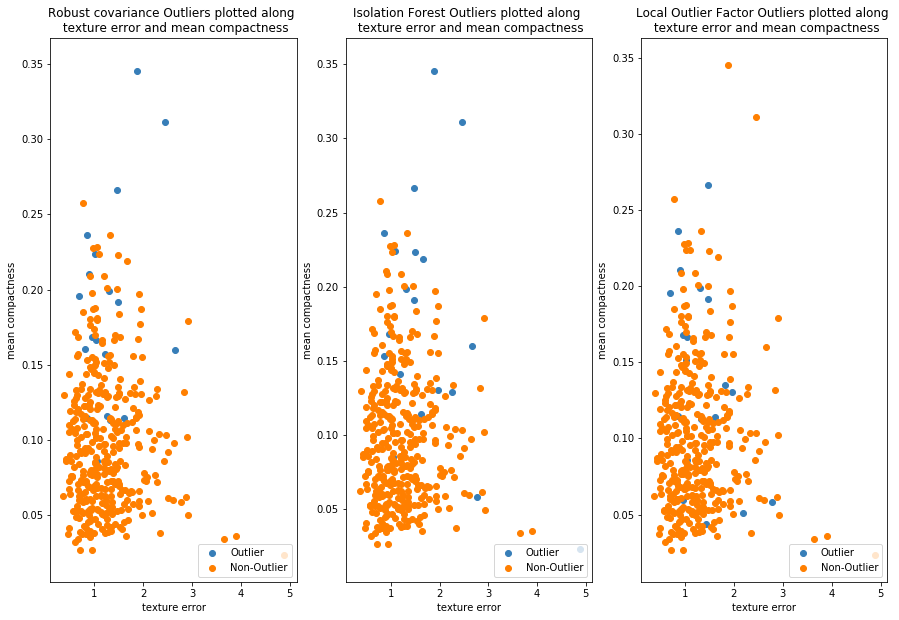

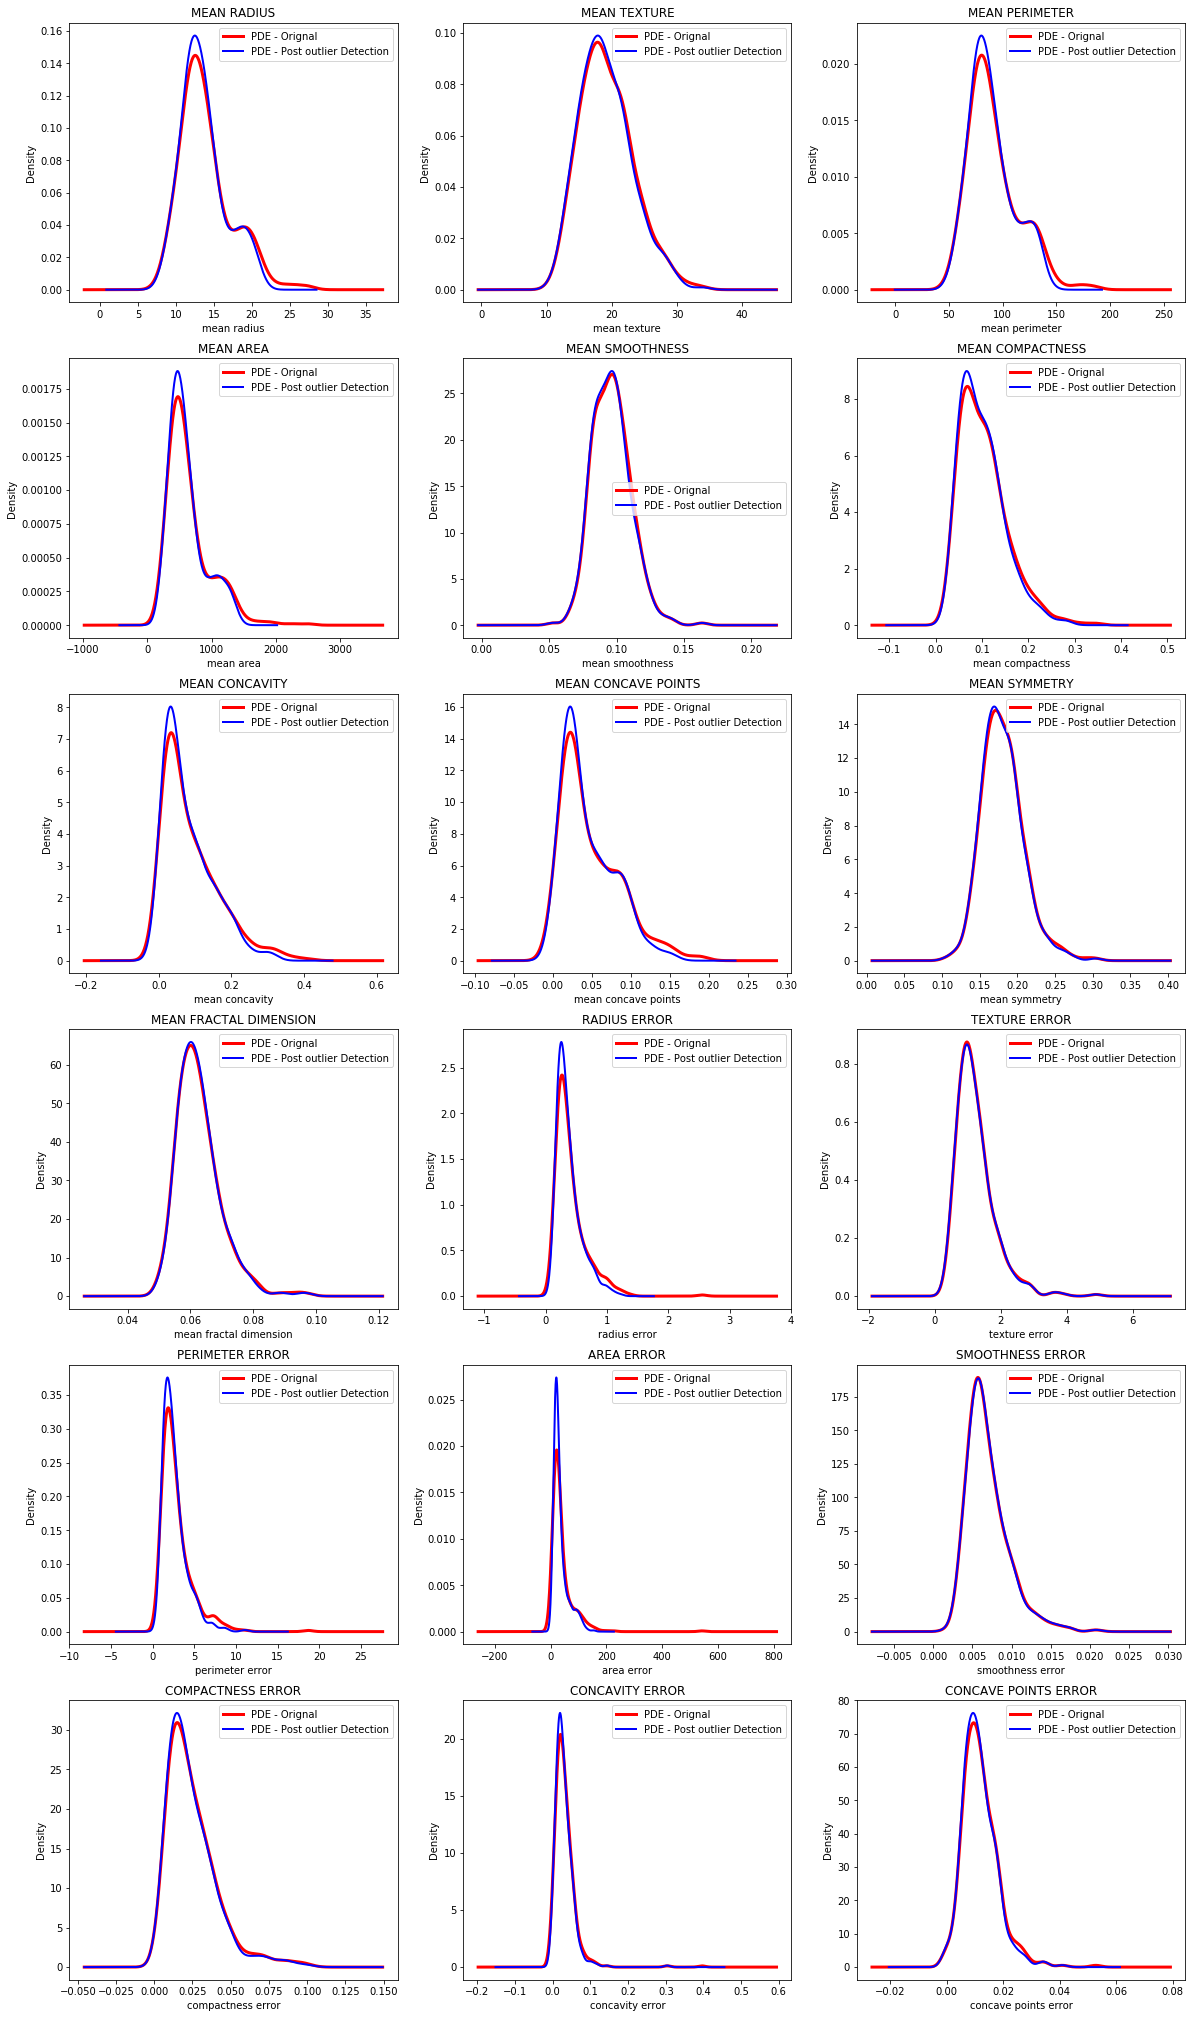

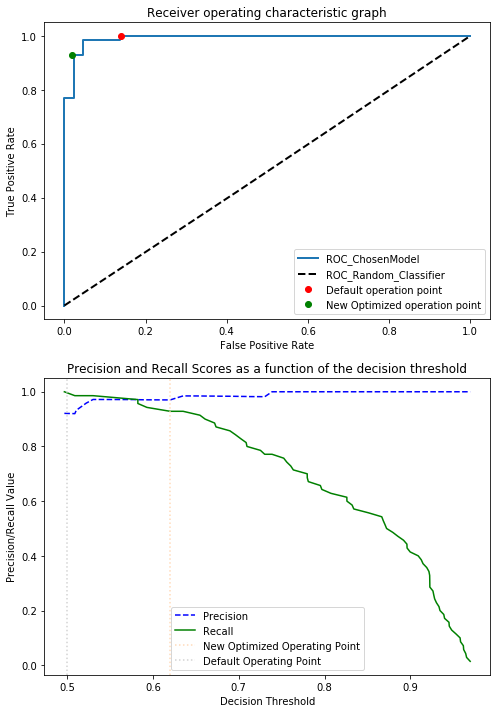

In [4]:
# Before inputting your dataset into dat_preprocess make sure no date time vars are there
# Also for one hot encoding provide a list containing the categorical variables as the last parameter
# dat_preprocess - # 1.Removes outcome variables with missing vals
                   # 2.Predictors with greater than X% missing (set as 30 below)
                   # 3. Label encoding the Y variable
                   # Split into train, test, dev set standard sizes(dev = 0.2, test = 0.1)
X_train,X_dev, X_test,Y_train,Y_dev,Y_test = dat_preprocess(df,'outcome',30,['cat1','cat2'])


# Runs outlier detection on all predictors 3 models offered (RC,IF,LOF) default IF.
# and removes the top most outliers capable of distorting the model results (default contamintation = 0.05)
X_train_nooutlier,Y_train_nooutlier = \
outlier_det(X_train,Y_train,'texture error','mean compactness','Robust covariance',0.05)   

# Visualize the effect of outlier elimination on all predictors using Kernal Density Plots
outlier_analysis(X_train,X_train_nooutlier)

# Main Training function does the following :- 
# 1.Standardization using standard scaler (x-u)/SD
# 2.Imputation (3rd Argument) using One vs all approach following models offered BaysRidge(bays),RFregressor(Rf),Knn(Knn)
# 3.Feature selection (1st Argument) using  KBest, L1 or PCA
# 4.Model Fitting (2nd Argument) - 2 types of Classification models offered Tree Based(Gradient Boosting, RF) ,
#   Regression Based (Logistic Regression and SVM). 
# 5.Hyperparameter search (4th Argument). Both Grid and Random Search offered.
# 6.Train on best found Hyper Parameter's on X_train
# 7.Returns prediction on dev and test sets along with best chosen Hyper parameters for all models in 
#  selected category of either Tree Based or Regression Based
Train_res = make_train_pipe('PCA','Tree_based','bays','Random',10,'accuracy', 
                            X_train_nooutlier,Y_train_nooutlier,X_dev,X_test,123)


# Tunes the ROC based on Different FP and FN costs 
# and plots default vs new operation point both on AUC and PR curves
# Note:- Does not support MULTI CLASS CLASSIFICATION
tuned_pred = tune_roc(Train_res['rf'][1],Y_dev,fn_cost=1,fp_cost=5,Y_test_pred_prob =Train_res['rf'][2])

# Evaluates final performance on the untouched Test set for the optimized operating 
# point above.
# Note:- Skip tuned_pred above for Multiclass classification
final_mod_perf(tuned_pred,Y_test,no_output_class = 2)



# THE END